**Lab 2** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Machine Learning for Audio and Acoustic Engineering***
---

# **Before you start**

*   Go to "*File*" --> "*Save a copy in Drive*"
*   Open that copy (might open automatically)
*   Then continue below

# **Lab 2: Introduction to ML Methods in Audio**
In this lab we will explore some well-known Machine Learning methods making use of the Scikit-Learn library. We'll go through matrix factorization methods and some popular supervised and unsupervised learning techniques.

---

# Exercise 1. Import libraries

* We need a number of libraries. Import them once to use throughout the document.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
import librosa, librosa.display
import IPython
from pathlib import Path
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

---

# Exercise 2. Fetch the Dataset

*   ESC-50: a dataset for Environmental Sound Classification (https://github.com/karolpiczak/ESC-50, https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)
 * 50 classes,  40 files per class, 5s clips
*   Download & unzip the dataset running the cell below. This will take a minute. You will see the new files on the left (folder icon).

In [78]:
#!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
#!unzip master.zip
#!rm master.zip


---

# Exercise 3. Metadata and analysis I

***Tasks:***
* Use pandas to read the csv file in *ESC-50-master/meta/*
* Print the first elements of the csv. Pandas has a standard function for this.
* Print the list of *unique* class labels in the dataset, and check whether there really are 50 of them

In [79]:

# Path to the CSV file
fn_csv = 'ESC-50-master/meta/esc50.csv'

# Read the CSV file using pandas
df = pd.read_csv(fn_csv)

# Print the first few rows of the dataset
print(df.head())

# Get the unique class labels
unique_classes = df['category'].unique()

# Print the number of unique classes and check if there are 50
print(unique_classes)
print(f"Number of unique classes in the dataset: {len(unique_classes)}")


            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_wa

Expected output:
```
    filename            fold  target  category        esc10   src_file  take
0   1-100032-A-0.wav    1     0       dog             True    100032    A
1   1-100038-A-14.wav   1     14      chirping_birds  False   100038    A
2   1-100210-A-36.wav   1     36      vacuum_cleaner  False   100210    A
3   1-100210-B-36.wav   1     36      vacuum_cleaner  False   100210    B
4   1-101296-A-19.wav   1     19      thunderstorm    False   101296    A
```

```
Unique classes: ['dog' 'chirping_birds' ... ]
Count: 50
```

---

# Exercise 4. Metadata and analysis II

* View and listen to some examples in the dataset to get a "feeling" for the sound classes.

vacuum_cleaner


vacuum_cleaner


thunderstorm


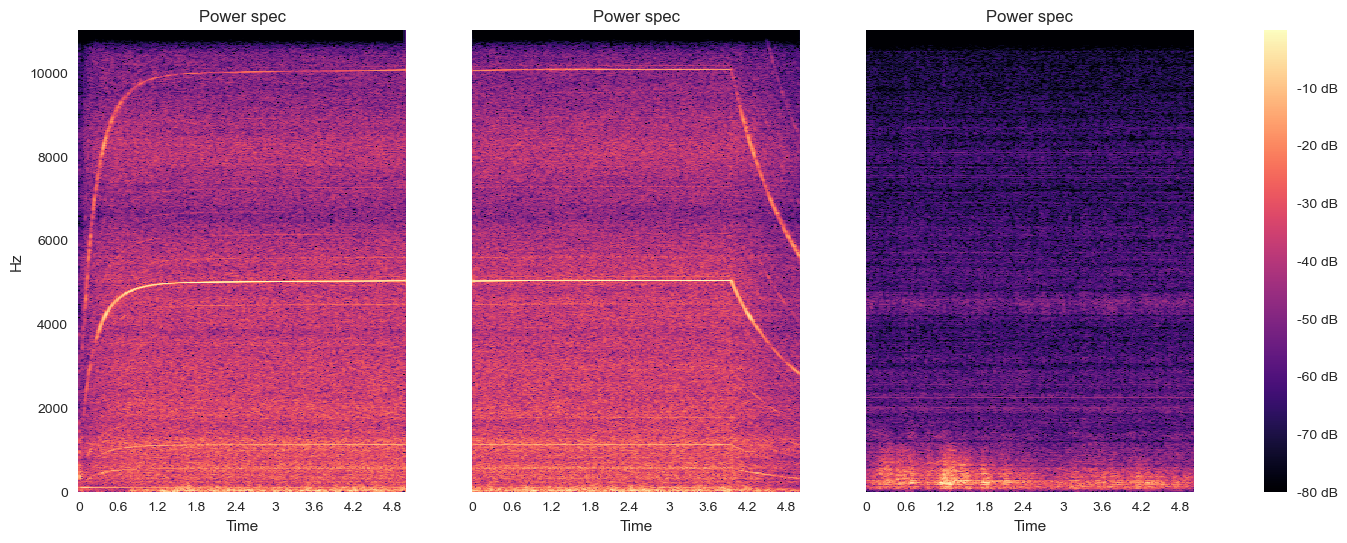

In [80]:
# Setup some filepaths
path = 'ESC-50-master/audio/'
file0 = path + df['filename'][2]  # We use indices [2-4] here, feel free to choose other files
file1 = path + df['filename'][3]
file2 = path + df['filename'][4]

# Show audio player for each file
print(df['category'][2])
IPython.display.display(IPython.display.Audio(data=file0))
print(df['category'][3])
IPython.display.display(IPython.display.Audio(data=file1))
print(df['category'][4])
IPython.display.display(IPython.display.Audio(data=file2))

# Plot mel specs
files = [file0, file1, file2]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i in range(3):
  y, sr = librosa.load(files[i])
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
  img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax[i])
  ax[i].set(title='Power spec')
  ax[i].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

---

# Exercise 5. ESC-5: Curation

Let's select 2 classes (*our_classes=['dog', 'rooster']*) from ESC-50 to make things a bit faster.

***Tasks:***
* Collect all files that belong to *our_classes*.
* Put the files and their respective classes in separate lists. Make sure their indices are equal (meaning: the value at index 3 of list *A* is related to the value at index 3 of list *B*).
  * Idea 1: Use *df.values* to iterate over the rows of the csv
  * Idea 2: Use *df.query('category in @our_classes')*
* Print the first 5 elements of each list as (file, class)-tuples. Also, print the overall lengths of the lists.

In [81]:
# Define the classes to filter
our_classes = ['dog', 'rooster']  # This will also serve as a class map later.

# Initialize empty lists for file names and class labels
esc5_X = []  # File list
esc5_y = []  # Class list

# Path to the CSV file
fn_csv = 'ESC-50-master/meta/esc50.csv'

### START CODING ###
# Load the CSV file into a DataFrame
df = pd.read_csv(fn_csv)

# Filter the DataFrame to only include rows where 'category' is in our_classes
df_filtered = df.query('category in @our_classes')

# Populate the lists
esc5_X = df_filtered['filename'].tolist()  # List of filenames
esc5_y = df_filtered['category'].tolist()  # Corresponding class labels

# Print the first 5 elements of each list as (file, class) tuples
print(list(zip(esc5_X[:5], esc5_y[:5])))

# Print the lengths of the lists
print(f'Lengths: {len(esc5_X)}, {len(esc5_y)}')

[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-26806-A-1.wav', 'rooster'), ('1-27724-A-1.wav', 'rooster'), ('1-30226-A-0.wav', 'dog')]
Lengths: 80, 80


Expected output:
```
[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-26806-A-1.wav', 'rooster'), ('1-27724-A-1.wav', 'rooster'), ('1-30226-A-0.wav', 'dog')]
Lengths: esc5_X: 80, esc5_y: 80
```



# Exercise 6. NMF Decomposition
The following code picks one signal of class 'dog' and class 'rooster' and mix both signals together in a new array called 'audiomix'.

**Note:** Listen to the signals and make sure the signal is active in most of the audio duration.

In [82]:
import IPython.display as ipd
# Convert esc5_y to a NumPy array to allow boolean indexing
esc5_y = np.array(esc5_y)
esc5_X = np.array(esc5_X)

# Select a file from the 'dog' and 'rooster' classes
dogs_files = esc5_X[esc5_y == 'dog'][0]  # First 'dog' file
rooster_files = esc5_X[esc5_y == 'rooster'][0]  # First 'rooster' file

### START CODING ###
# Load the audio files
signal_0, sr = librosa.load(path + dogs_files)
signal_1, _ = librosa.load(path + rooster_files)

### END CODING ###

# Play the sounds
print('Dog example')
ipd.display(ipd.Audio(signal_0, rate=sr))

print('Rooster example')
ipd.display(ipd.Audio(signal_1, rate=sr))

# Compute the mixture of the two signals
audiomix = signal_0 / np.max(signal_0) + signal_1 / np.max(signal_1)
audiomix = 0.5 * audiomix / np.max(audiomix)

print('Mixture')
ipd.display(ipd.Audio(audiomix, rate=sr))

Dog example


Rooster example


Mixture


Now let's compute the spectrogram of the mixture and decompose the magnitude information using NMF with 2 components (see librosa.decompose.decompose):

In [83]:
# Compute the STFT of the mixed signal
S = librosa.stft(audiomix)

# Compute the magnitude and phase
X, X_phase = librosa.magphase(S)

### START CODING ###
from librosa.decompose import decompose

# Apply NMF with 2 components
W, H = decompose(X, n_components=2)

# Print the shapes of W and H
print(W.shape, H.shape)

(1025, 2) (2, 216)


Expected output:
```
(1025, 2) (2, 216)
```

Compare the original and approximated spectrum:

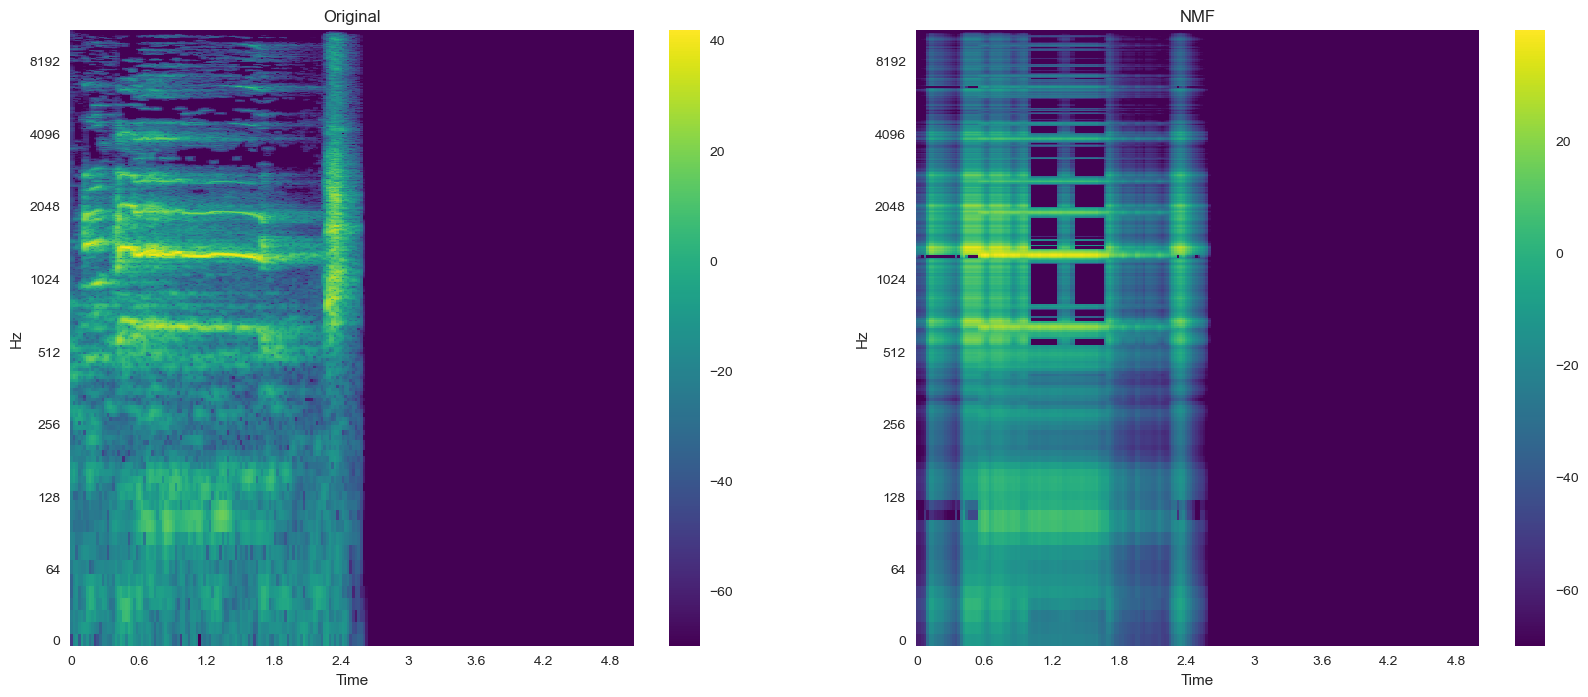

In [84]:
plt.figure(figsize=(20,8))

#original
plt.subplot(1,2,1)
librosa.display.specshow(20*np.log10(X+np.finfo(float).eps), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('Original')
plt.clim([-70, None])
plt.colorbar()

#after NMF
plt.subplot(1,2,2)
librosa.display.specshow(20*np.log10(np.dot(W,H)+np.finfo(float).eps), sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('NMF')
plt.clim([-70, None])
plt.colorbar();

# **Analysis of the Spectrograms: Original vs. NMF Decomposition**

The two plots represent the **Short-Time Fourier Transform (STFT)** of a mixed audio signal before and after applying **Non-negative Matrix Factorization (NMF)**.

- **Left (Original Spectrogram)**:  
  This spectrogram displays the original distribution of energy over time and frequency. The sound components are overlapped, making it difficult to distinguish individual sources in the mixture.

- **Right (NMF Spectrogram)**:  
  After applying **NMF**, the signal is decomposed into more **sparse and structured components**, highlighting specific patterns that were previously blended in the original mix.  
  The presence of **black bands** and well-defined regions in the spectrogram suggests that the model has identified and isolated **recurring frequency patterns**, reducing the influence of less relevant elements. This indicates that NMF has learned to distinguish the **dominant spectral structures**, partially separating them in both time and frequency domains.  

While the original spectrogram displayed a more continuous and diffused energy distribution, the NMF decomposition reveals **localized and coherent components**, showing that the model successfully extracted characteristic spectral signatures of different sound sources. This process is fundamental for source separation, allowing the isolation of individual acoustic contributions within a complex audio mixture.
By identifying recurring frequency patterns (`W`) and their temporal activations (`H`), NMF separates overlapping sounds, revealing structured components.  





Now let's represent the learned spectral patterns and temporal activations for each component:

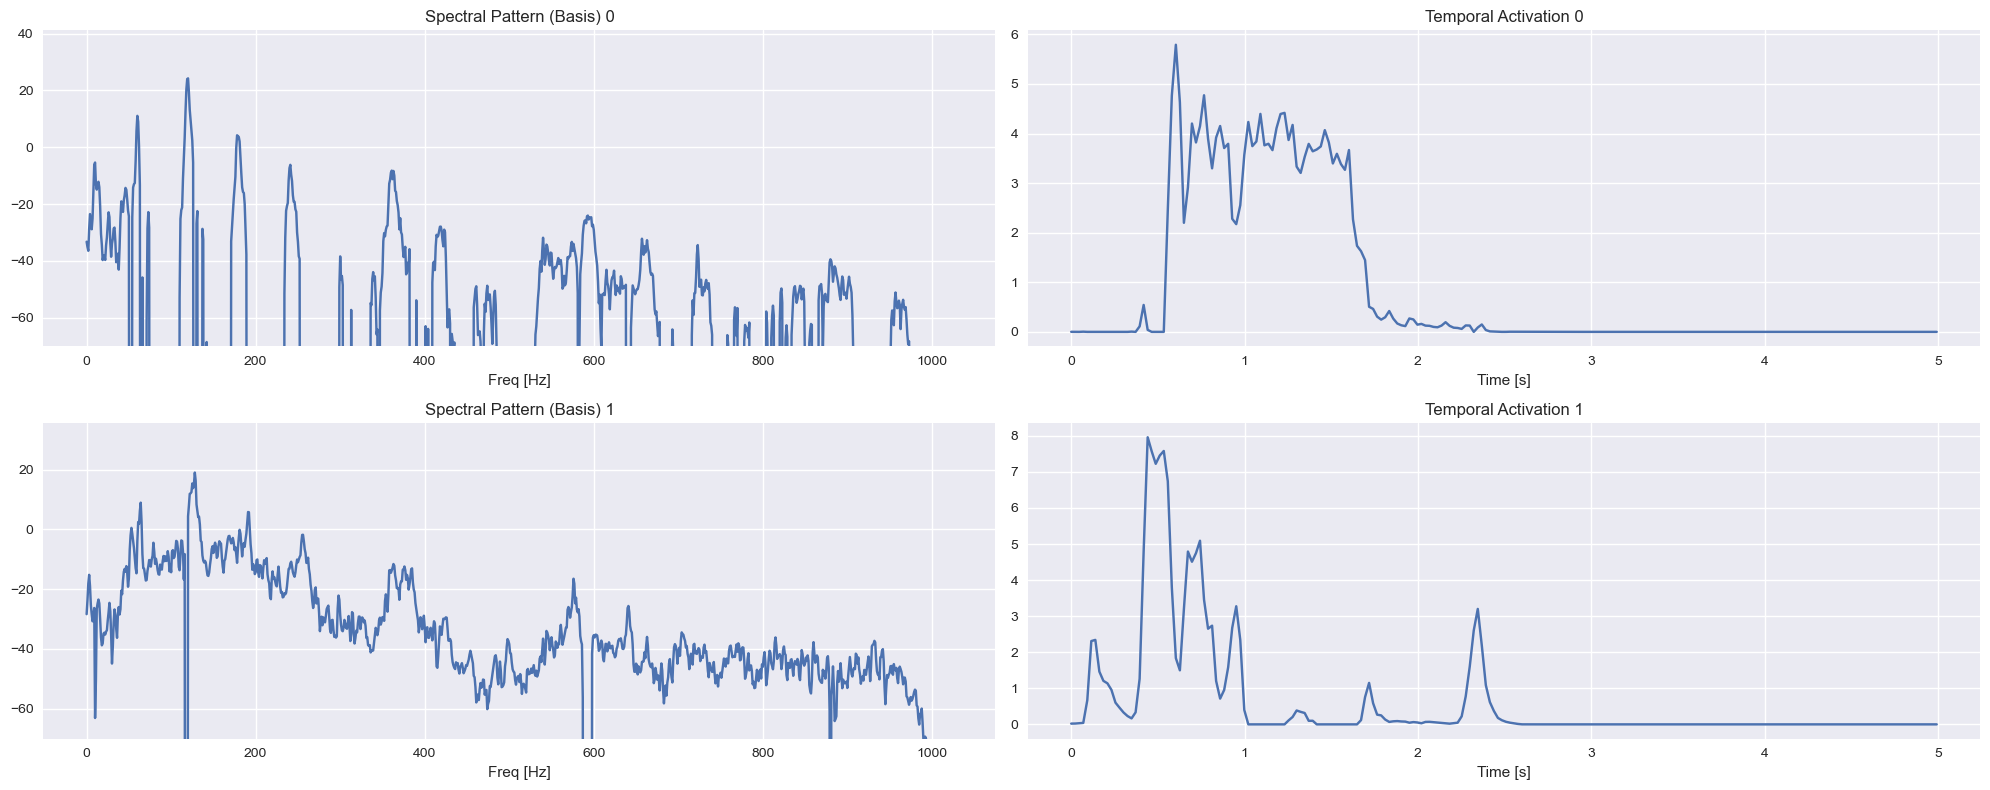

In [85]:
# Convert frames to time
t_frames = librosa.frames_to_time(np.arange(H.shape[1]))

# Initialize plotting
plt.figure(figsize=(20, 8))
plot_iter = 1  # Subplot iterator

# Number of components
n_components = H.shape[0]

for i in range(n_components):
    # Plot spectral pattern (basis)
    plt.subplot(2, n_components, plot_iter)
    plt.plot(20 * np.log10(W[:, i] + np.finfo(float).eps))
    plt.xlabel('Freq [Hz]')
    plt.title(f'Spectral Pattern (Basis) {i}')
    plt.ylim(bottom=-70)
    plot_iter += 1

    # Plot temporal activation
    plt.subplot(2, n_components, plot_iter)
    plt.plot(t_frames, H[i, :])
    plt.xlabel('Time [s]')
    plt.title(f'Temporal Activation {i}')
    plot_iter += 1

plt.tight_layout()
plt.show()


Finally let's reconstruct the temporal signal of each component (use the phase information of the original mix signal) and listen to the result.

In [86]:
# List to store the reconstructed signals
reconstructed_signals = []

### START CODING ###
for i in range(n_components):
    # Reconstruct the component by combining magnitude (W * H) with original phase
    component = np.dot(W[:, i:i+1], H[i:i+1, :]) * X_phase

    # Convert back to time domain using ISTFT
    signal_reconstructed = librosa.istft(component)

    # Store the reconstructed signal
    reconstructed_signals.append(signal_reconstructed)

    # Play the audio component
    print(f'Component: {i}')
    ipd.display(ipd.Audio(signal_reconstructed, rate=sr))

Component: 0


Component: 1


### **Comment on NMF Separation Results**  

After listening to the two reconstructed audio signals, it is clear that **they do not perfectly match the original sounds**. The dog's bark, in particular, has lost its clarity and sounds less natural. This happens because NMF **does not directly separate the original sources** but rather decomposes the signal into **dominant components**, which may contain elements of both sounds. Additionally, the model operates only on the **magnitude** of the spectrum, while the phase is approximated, introducing distortions.  

The limitation to only two components also affects the separation quality, forcing the algorithm to distribute all spectral content into just two categories, which can lead to overlapping between sources. While NMF is useful for highlighting recurring structures, achieving a more faithful separation of the original sounds would require more advanced techniques such as **deep learning models**.


# Exercise 7. Harmonic-Percussive Decomposition
Now, apply librosa's harmonic-percussive source separation to extract again two components.
**Tasks**
*   Compute the harmonic-percussive (see librosa.decompose.hps)
*   Display the harmonic and the percussive spectrograms
*   Listen to the obtained results
*   Discuss the differences between the standard NMF and the Harmonic-Percussive separation.

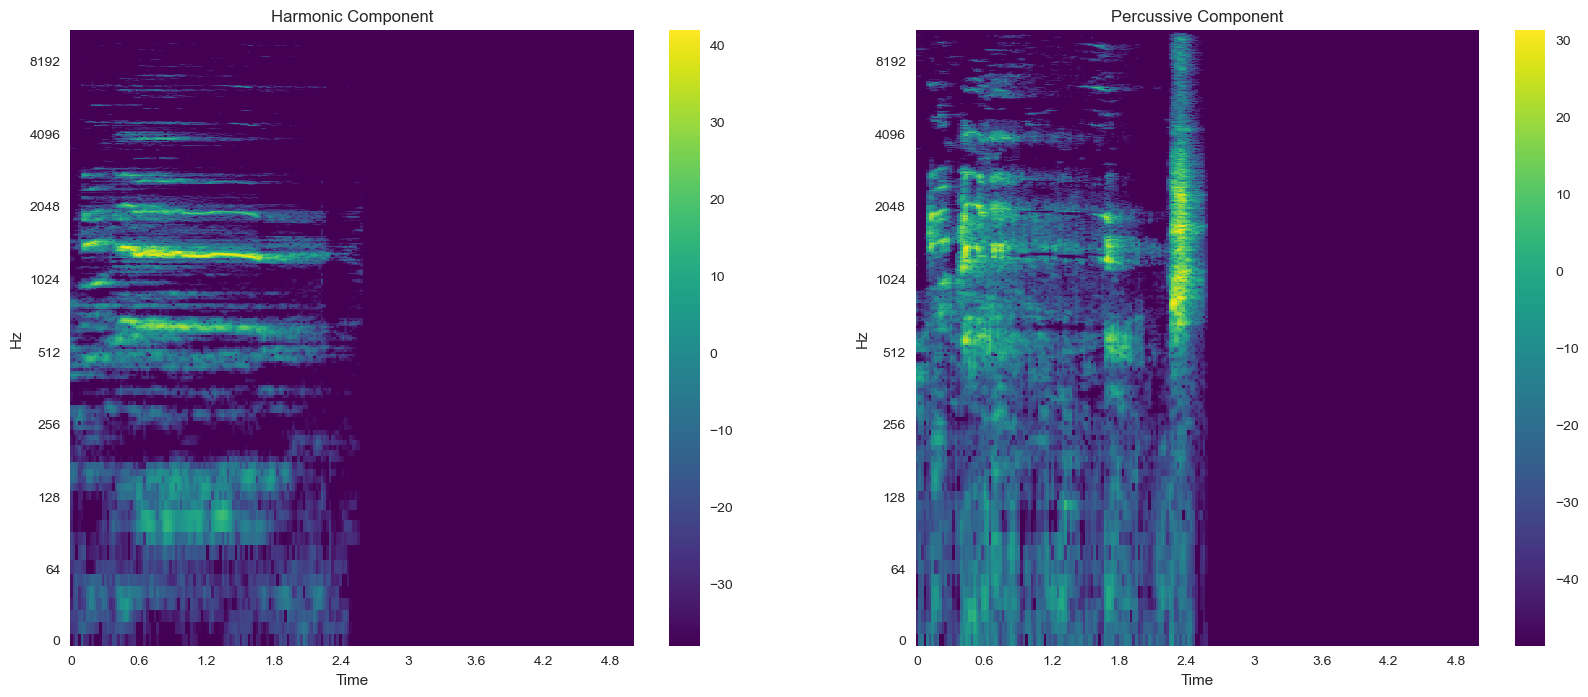

In [87]:
# Compute the harmonic-percussive decomposition
Hmm, Prs = librosa.decompose.hpss(X)

# Listen to the extracted components
ipd.display(ipd.Audio(librosa.istft(Hmm), rate=sr))
ipd.display(ipd.Audio(librosa.istft(Prs), rate=sr))



Hmag = librosa.amplitude_to_db(Hmm)
Pmag = librosa.amplitude_to_db(Prs)
# Plot the harmonic and percussive components 
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
librosa.display.specshow(Hmag, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('Harmonic Component')
plt.colorbar();

plt.subplot(1,2,2)
librosa.display.specshow(Pmag, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.title('Percussive Component')
plt.colorbar();
     



### **Comment on HPSS Separation Results of the Audio**  

After applying **harmonic-percussive separation**, we notice that the first audio (harmonic component) contains the **rooster’s sound more clearly**, while the second audio (percussive component) still includes the rooster but in a more **distorted form**, along with the dog's bark, which also appears somewhat distorted.  

This result aligns with the expected behavior of HPSS:  
- **The harmonic component retains sustained and tonal elements**, which is why the rooster’s call is dominant in this part.  
- **The percussive component captures transient sounds and sharp attacks**, which is why we still hear the rooster but with more distortion, and also the dog's bark, which has more percussive characteristics.  

Unlike **NMF**, which extracts dominant spectral patterns based on statistical decomposition, HPSS strictly separates the sound based on its **temporal structure**, distinguishing between **sustained (harmonic) and transient (percussive) components**. As a result, some overlapping information remains in both outputs, and the separation is not perfect. However, HPSS is still useful for emphasizing rhythmic vs. melodic elements in an audio signal.

### **Comment on the Spectrograms**
The spectrogram on the left represent the harmonic contribution, as we can recognize from the horizontal harmonic lines. On the other hand, the spectrogram on the right represent the temporal contribution. In fact, the temporal lines are spreaded vertically in the frequency axis, showing a percussive transient.

# Exercise 8. Feature Extraction
Compute the mean ZCR and standard deviation of the spectral flatness for the examples in signals_0 (dogs) and signals_1 (rooster). Define a function to extract those features (call it 'extract_features') and store the extracted features into two arrays: 'dog_features' and 'rooster_features'

In [88]:

# Function definition
def extract_features(signal):
    return [np.mean(librosa.feature.zero_crossing_rate(y=signal)[0,:]),
            np.std(librosa.feature.spectral_flatness(y=signal)[0,:]),]



In [89]:
# Feature Extraction
signal_0= [librosa.load(path + x)[0] for x,y in zip(esc5_X, esc5_y) if y == 'dog']
signal_1= [librosa.load(path + x)[0] for x,y in zip(esc5_X, esc5_y) if y == 'rooster']

dog_features = np.array([extract_features(x) for x in signal_0])
rooster_features = np.array([extract_features(x) for x in signal_1])

print(dog_features.shape)  # 40 samples, 2 features each
print(rooster_features.shape)

(40, 2)
(40, 2)


Expected output:
```
(40, 2)
(40, 2)
```

Represent the histograms for each feature for the two classes and discuss which of the two features seems to be better for classification.

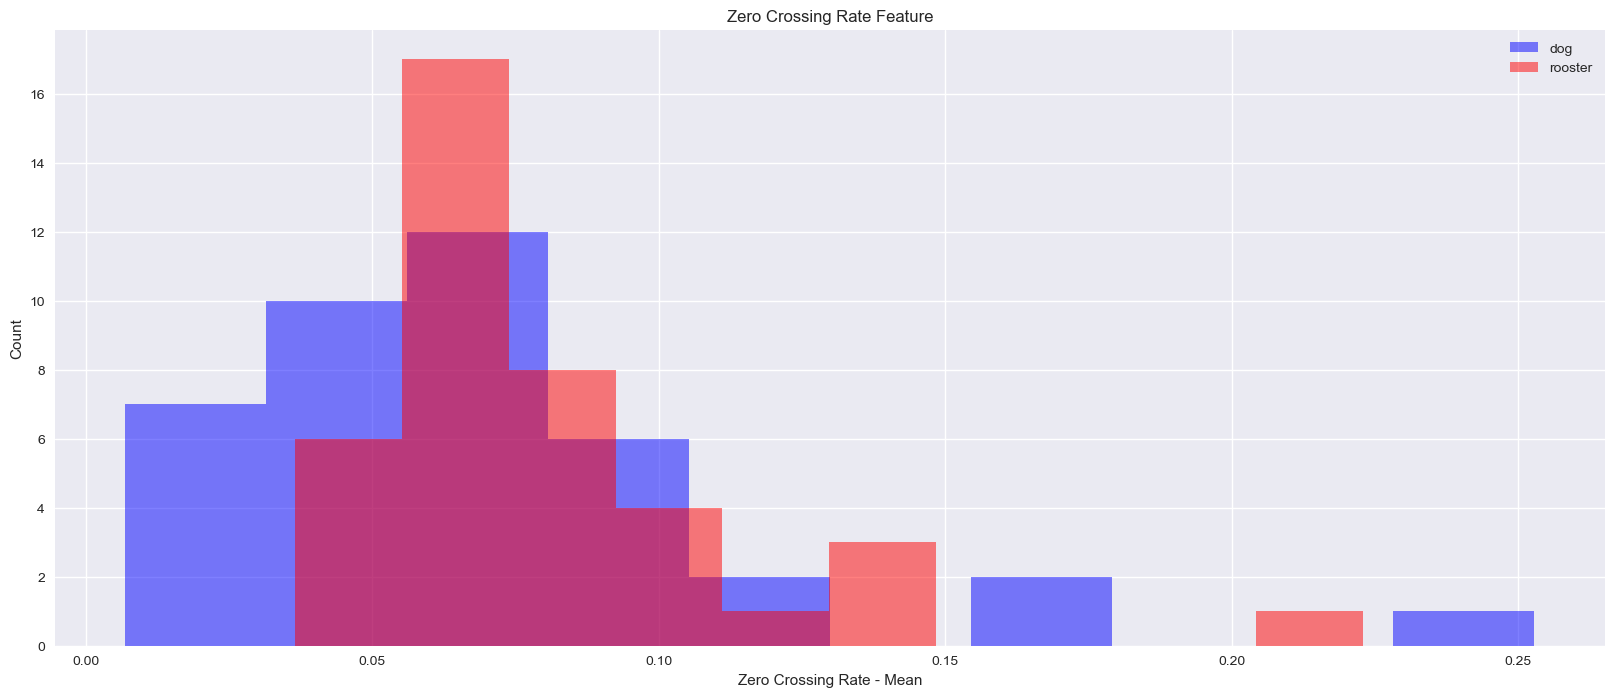

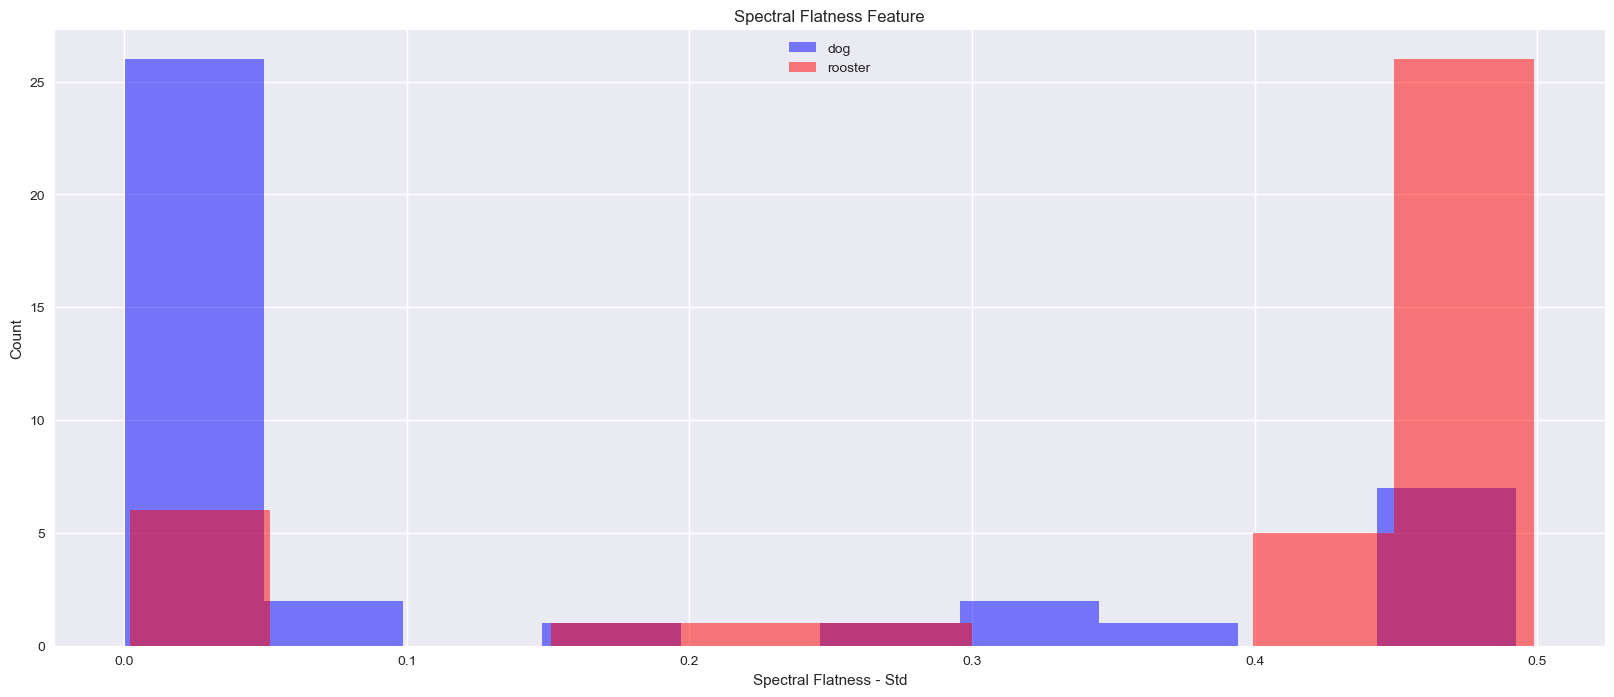

In [90]:
# First feature (ZCR)
plt.figure(figsize=(20,8))
plt.hist(dog_features[:,0], color='b', alpha=0.5, bins=10)
plt.hist(rooster_features[:,0], color='r', alpha=0.5, bins=10)
plt.title('Zero Crossing Rate Feature')
plt.legend(('dog','rooster'))
plt.xlabel('Zero Crossing Rate - Mean')
plt.ylabel('Count');

# Second feature (SF)
plt.figure(figsize=(20,8))
plt.hist(dog_features[:,1], color='b', alpha=0.5, bins=10)  # Blue  
plt.hist(rooster_features[:,1], color='r', alpha=0.5, bins=10)  # Red
plt.title('Spectral Flatness Feature')
plt.legend(('dog','rooster'))
plt.xlabel('Spectral Flatness - Std')
plt.ylabel('Count');


### Feature Analysis

Analyzing the results from our two audio clips we observe clear differences in their acoustic characteristics.

The first feature, **Zero Crossing Rate (ZCR)**, measures how often the signal changes sign (i.e., crosses the zero amplitude line).  
- A **high ZCR** indicates a noisier signal with more high-frequency content.  
- A **low ZCR** corresponds to more stable, tonal sounds.  
In our case, the **dog bark** shows a **lower average ZCR**, suggesting a more compact and steady sound. The **rooster crow** has a **higher ZCR**, reflecting its more dynamic and oscillating structure.

The second feature, the **standard deviation of Spectral Flatness**, captures how evenly energy is distributed across the frequency spectrum.  
- A **high spectral flatness** (and high variability) is associated with noise-like signals.  
- A **low spectral flatness** suggests tonal sounds with dominant frequencies.  
Here, the **dog bark** has a **lower standard deviation**, indicating a more stable spectral profile. The **rooster crow** shows **greater variability**, consistent with its complex harmonic structure.

These two features — ZCR and spectral flatness — effectively capture the acoustic differences between our recordings, and can serve as valuable descriptors for classification tasks.


# Exercise 9. Principal Component Analysis
Redefine the feature extractor to extract 3 features, adding to the previous ones the mean value of the spectral centroid (see librosa.feature.spectral_centroid).

In [91]:
# Function definition
def extract_features(signal):
    return [
        np.mean(librosa.feature.zero_crossing_rate(y=signal)[0, :]),
        np.std(librosa.feature.spectral_flatness(y=signal)[0, :]),
        np.mean(librosa.feature.spectral_centroid(y=signal)[0, :])
    ]

In [92]:
# Feature Extraction
dog_features = np.array([extract_features(x) for x in signal_0])
rooster_features = np.array([extract_features(x) for x in signal_1])

print(dog_features.shape) #40 samples and 3 feature each
print(rooster_features.shape)

(40, 3)
(40, 3)


Expected output:
```
(40, 3)
(40, 3)
```

Create a matrix 'feature_table' stacking all the features a use sklearn 'scale' over such matrix. Create as well a label vector indicating the true label for each row of 'feature_table'

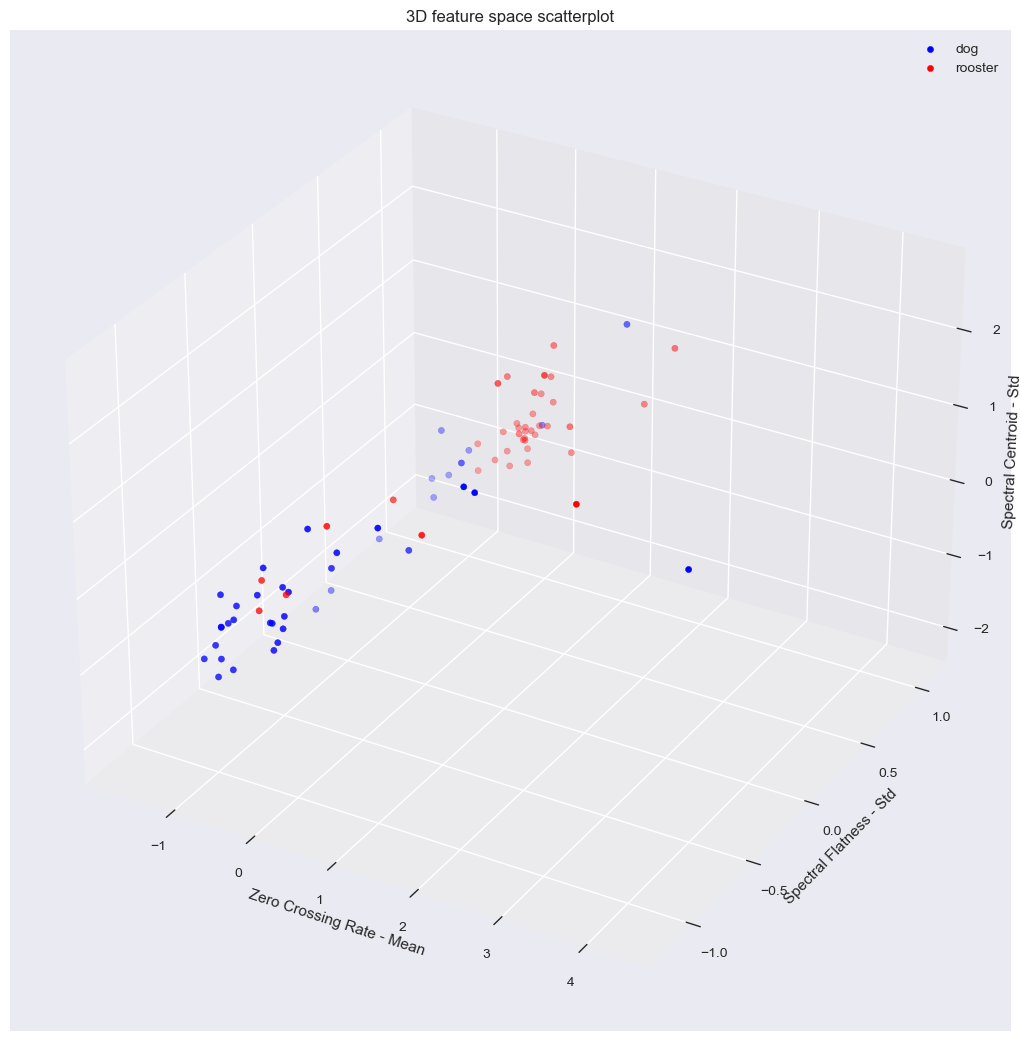

In [98]:
from sklearn.preprocessing import scale

feature_table = np.vstack((dog_features, rooster_features))
labels_gt = np.hstack((np.ones(len(dog_features)), np.zeros(len(rooster_features))))

# Scale the features
training_features = scale(feature_table, axis=0)

fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(training_features[labels_gt==1,0], training_features[labels_gt==1,1], training_features[labels_gt==1,2], c='b')
ax.scatter(training_features[labels_gt==0,0], training_features[labels_gt==0,1], training_features[labels_gt==0,2], c='r');
ax.legend(('dog','rooster'))
ax.set_title('3D feature space scatterplot')
ax.set_xlabel('Zero Crossing Rate - Mean')
ax.set_ylabel('Spectral Flatness - Std')
ax.set_zlabel('Spectral Centroid - Std');


Now apply PCA for reducing the dimensionality (see sklearn.decomposition.PCA) to two dimensions using whiten='true' and plot the corresponding scatterplot:

(80, 2)
(80,)


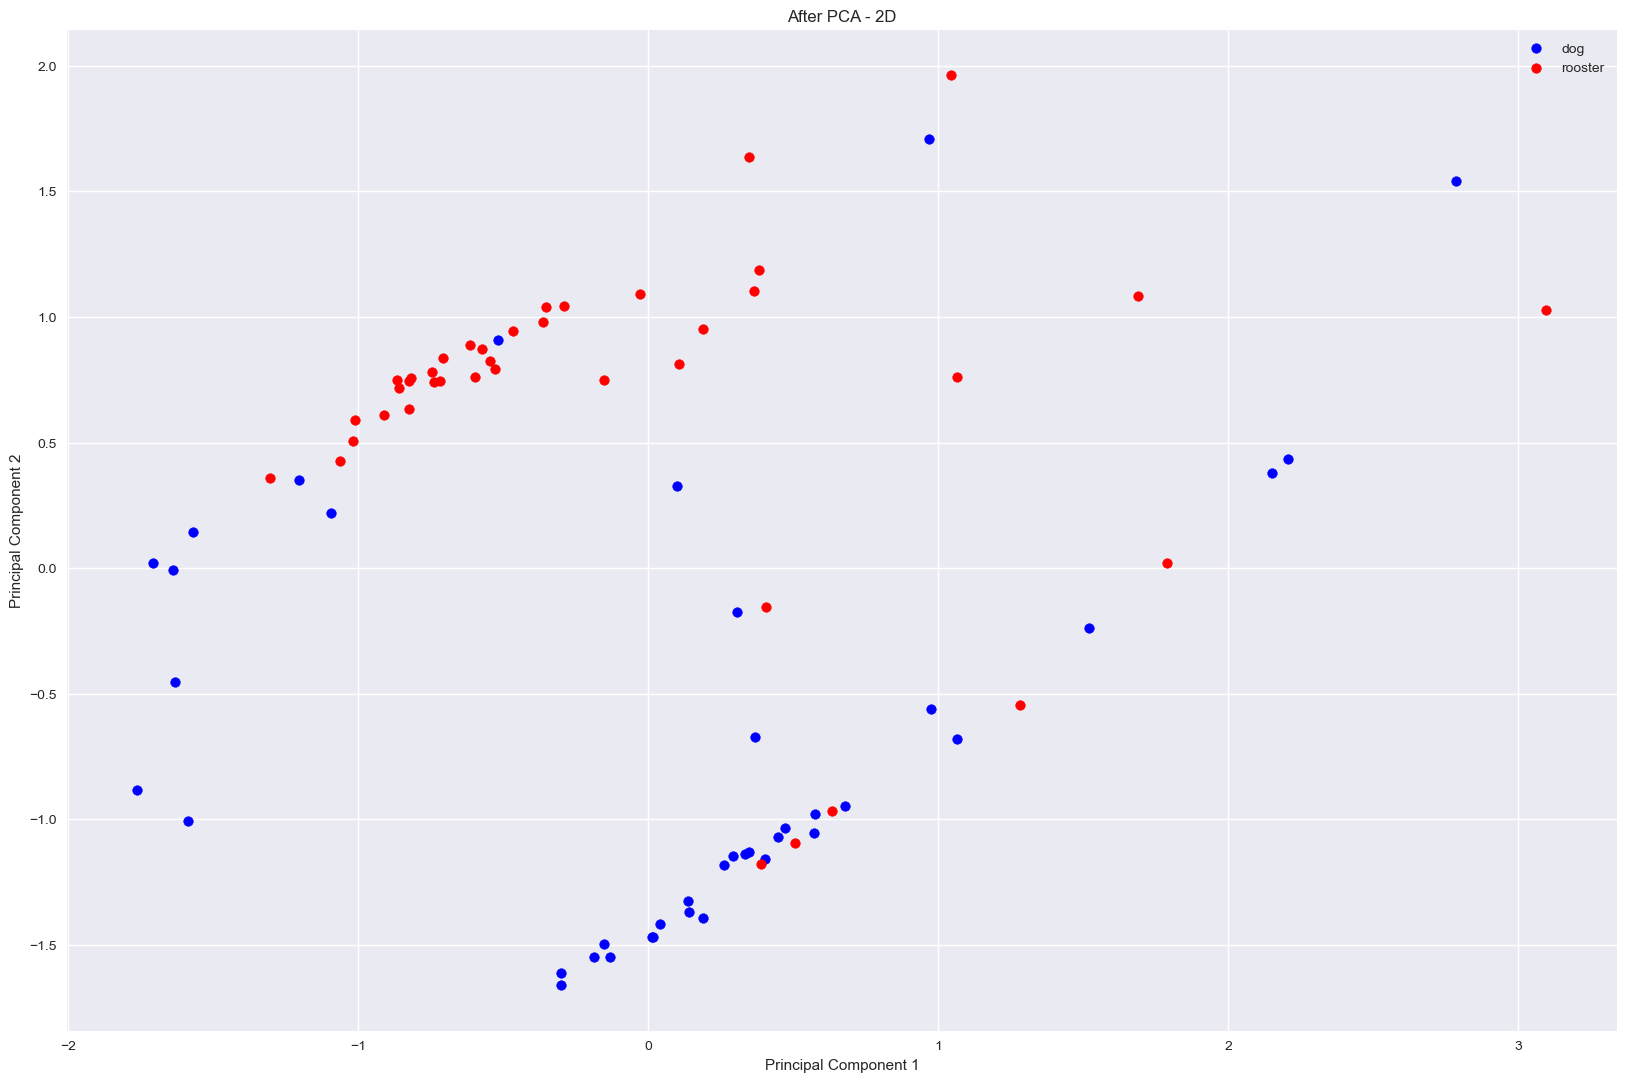

In [ ]:

# X = matrice 80x2 PCA, labels_gt = 80 label binarie
model_pca = PCA(n_components=2, whiten=True)
X = model_pca.fit_transform(training_features)


# Plotting the result
plt.figure(figsize=(20,13))
plt.scatter(Y[labels_gt==1,0], Y[labels_gt==1,1], c='b')
plt.scatter(Y[labels_gt==0,0], Y[labels_gt==0,1], c='r')
plt.title('After PCA - 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))
plt.show()

### PCA Scatterplot Analysis

The PCA projection onto 2D space reveals a clear separation trend between the two classes.  
The red points (rooster sounds) are mostly located in the upper-left region of the plot, while the blue points (dog barks) are spread more along the lower and right side.

This indicates that the PCA has successfully captured variance directions that help distinguish the two sound types.  
Although some overlap remains, especially near the center, the feature space appears to encode meaningful differences between the bark and crowing signals. This supports the idea that the extracted features (ZCR, spectral flatness, and spectral centroid) carry relevant information for class separation.


# Exercise 10. Support Vector Machine

Fit a linear SVM classifier with parameter C=1 to the PCA transformed data. Use the following helper function to draw the classifier hyperplanes of interest:

In [95]:
def draw_classplane(ax,model,xrange):
  w = model.coef_[0]
  b = model.intercept_[0]
  a = -w[0] / w[1]
  xx = np.linspace(xrange[0], xrange[1])
  yy = a * xx - (b/ w[1])
  margin = 1 / np.sqrt(np.sum(w** 2))
  yy_down = yy - np.sqrt(1 + a ** 2) * margin
  yy_up = yy + np.sqrt(1 + a ** 2) * margin
  ax.plot(xx, yy, 'k-')
  ax.plot(xx, yy_down, 'k--')
  ax.plot(xx, yy_up, 'k--')

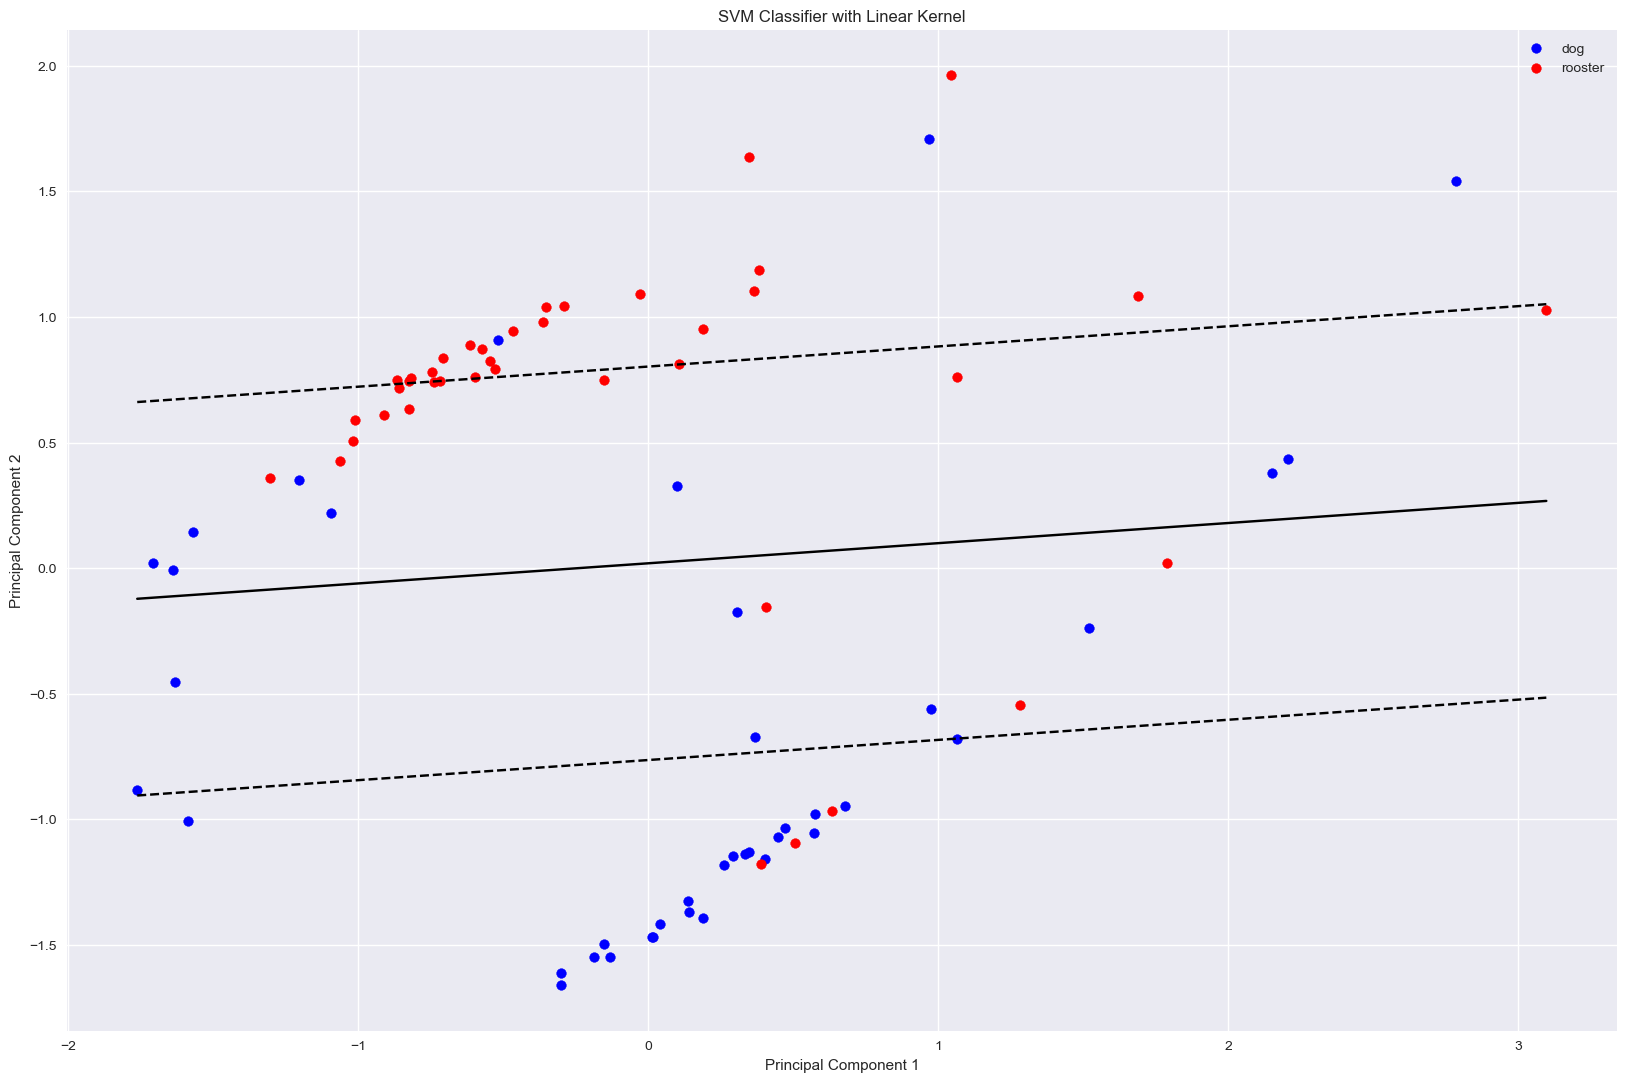

In [ ]:
from sklearn.svm import SVC

# Model fitting
model = SVC(kernel='linear', C=1)
model.fit(X, labels_gt)

# Model prediction (opzionale per valutazione)
Y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(20,13))
plt.scatter(X[labels_gt==1,0], X[labels_gt==1,1], c='b')
plt.scatter(X[labels_gt==0,0], X[labels_gt==0,1], c='r')
draw_classplane(plt.gca(), model, [X[:,0].min(), X[:,0].max()])
plt.title("SVM Classifier with Linear Kernel")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))
plt.show()


Represent two subplots to compare the ground truth data and the classification result. Plot the classification hyperplanes and margin using the provided function 'draw_classplane'

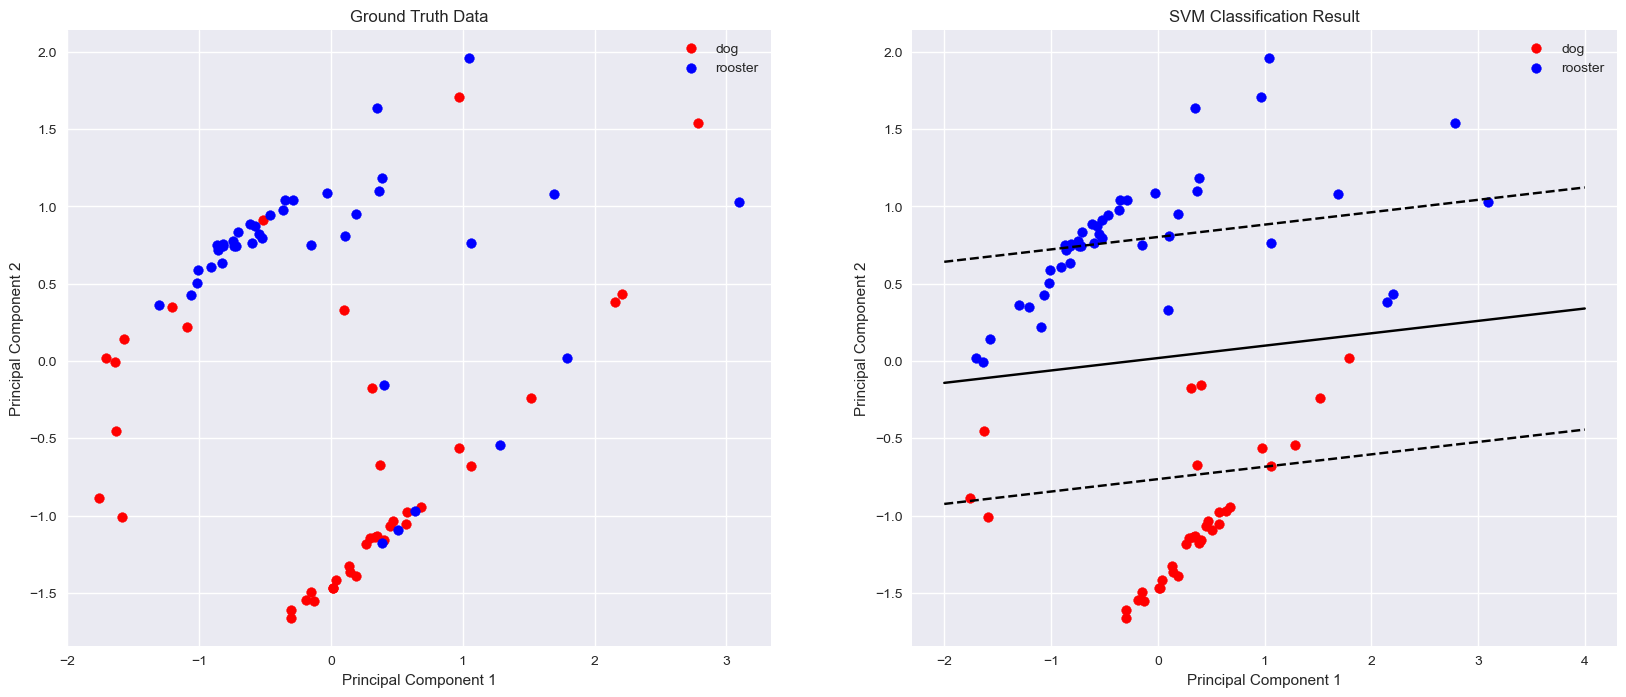

In [ ]:
plt.figure(figsize=(20,8))

# --- Ground Truth Data ---
plt.subplot(1,2,1)
plt.scatter(X[labels_gt==1,0], X[labels_gt==1,1], c='r')
plt.scatter(X[labels_gt==0,0], X[labels_gt==0,1], c='b')
plt.title('Ground Truth Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))

# --- Classification Result ---
plt.subplot(1,2,2)
plt.scatter(X[Y_pred==1,0], X[Y_pred==1,1], c='r')
plt.scatter(X[Y_pred==0,0], X[Y_pred==0,1], c='b')
plt.title('SVM Classification Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))

# Draw Hyperplane and Margins
draw_classplane(plt.gca(), model, [-2, 4])

plt.show()

Compute the accuracy of the classification result (use sklearn.metrics.accuracy_score).

In [102]:
acc = accuracy_score(labels_gt, Y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.7875


The classification accuracy is **0.7875**, meaning that nearly **79%** of the audio clips were correctly classified.  
This indicates a reasonably good performance, though there is still room for improvement, possibly by using additional features or tuning the classifier.


Expected output (might differ slightly):
```
Accuracy:  0.7875
```


Now, apply a RBF kernel for non-linear classification:

In [103]:
# Fit model with RBF kernel
model = SVC(kernel='rbf', C=1)
model.fit(X, labels_gt)

# Predict the labels
labels = model.predict(X)

Draw the resulting classification contour and compute the accuracy:

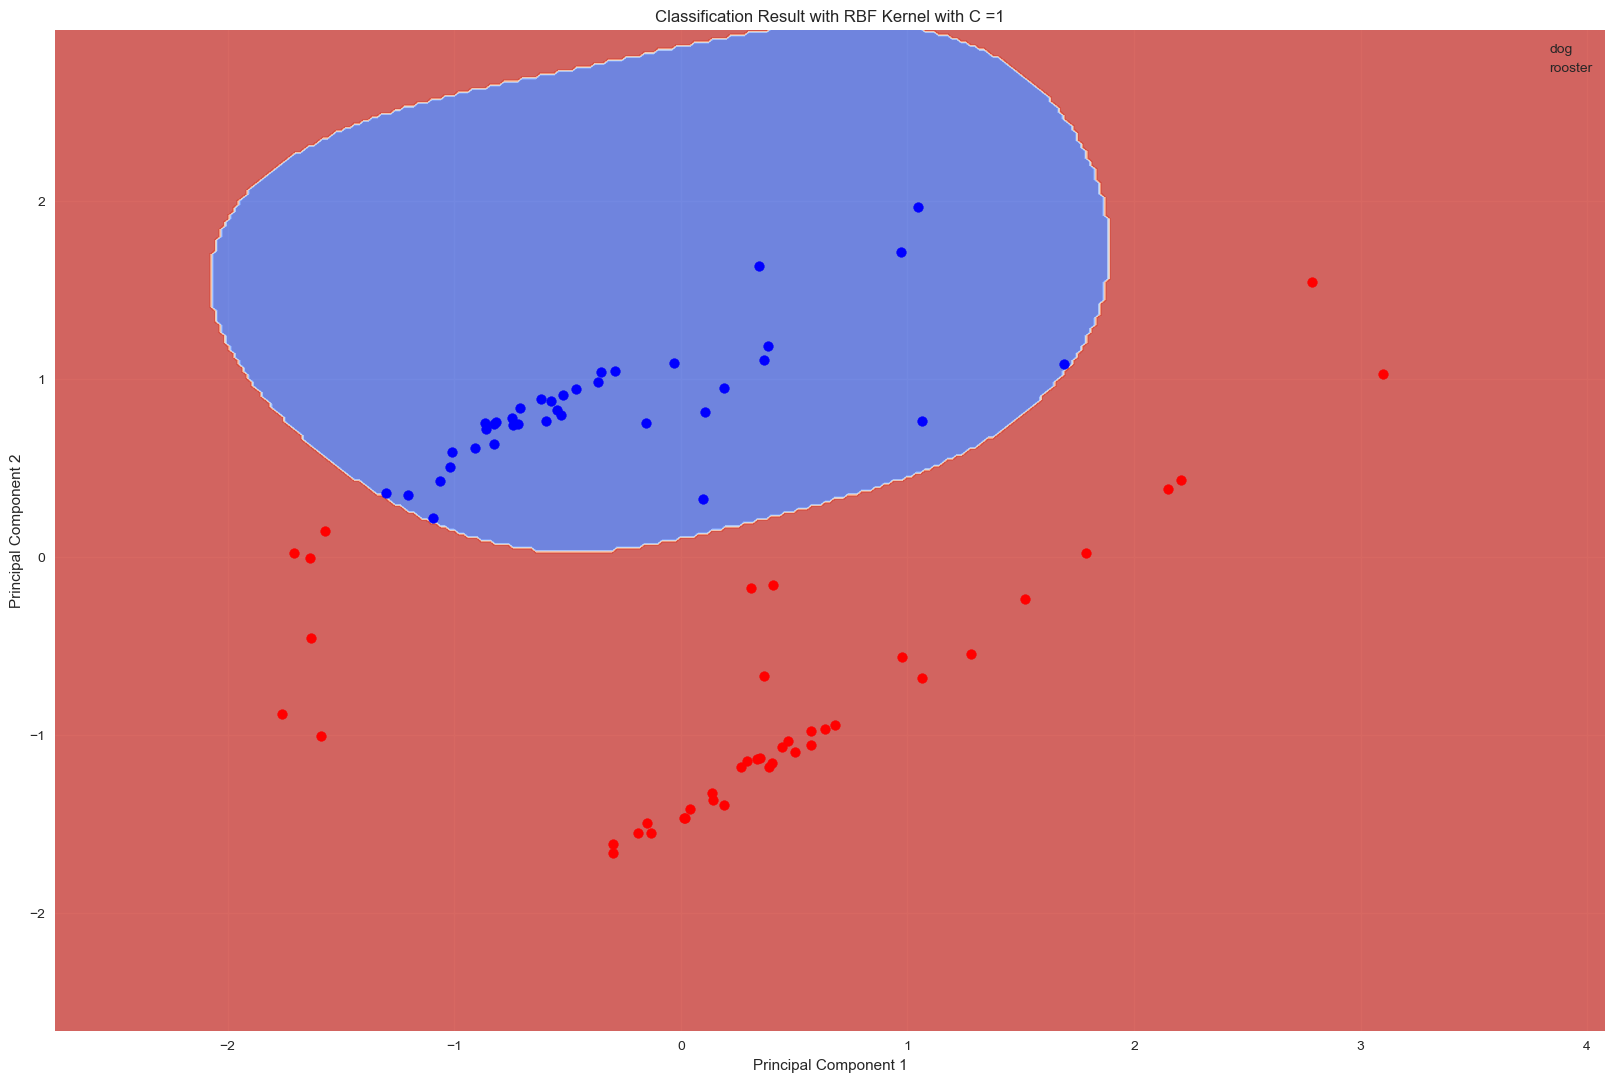

In [105]:
plt.figure(figsize=(20,13))

#for representation purposes
h = 0.02
x_min, x_max = Y[:,0].min() -1 , Y[:,0].max() +1
y_min, y_max = Y[:,1].min() -1 , Y[:,1].max() +1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min, y_max,h))
penalty = model.C

#display the boundary by predicting on every point on the grid
Z = model.predict(np.c_[ xx.ravel(), yy.ravel()])
# Put the result into color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.coolwarm, alpha = 0.8)

plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());

plt.scatter(Y[labels==1,0],Y[labels==1,1],c='r')
plt.scatter(Y[labels==0,0],Y[labels==0,1],c='b')
plt.title('Classification Result with RBF Kernel with C ={}'.format(penalty))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'));

The classification result using the RBF kernel shows a non-linear decision boundary that better separates the two classes compared to the linear classifier. The contour plot highlights how the model has successfully identified a curved boundary that surrounds the rooster class (blue), reducing the number of misclassifications. This indicates that the RBF kernel is more suitable for capturing complex patterns in the data.


In [ ]:

acc = accuracy_score(labels_gt, labels)
print('Accuracy: ', acc)

Accuracy:  0.85


The accuracy obtained with the RBF kernel is 0.85, which is an improvement over the previous linear classifier (which had an accuracy of 0.79). This suggests that the RBF kernel is more effective at capturing the non-linear structure of the data, leading to better separation between the two classes and fewer classification errors.


Expected output (might differ slightly):
```
Accuracy:  0.85
```

Experiment with different parameters of C. Try different values also for the "gamma" parameter of the RBF kernel.

Find a combination of parameters representing an overfitting and underfitting.

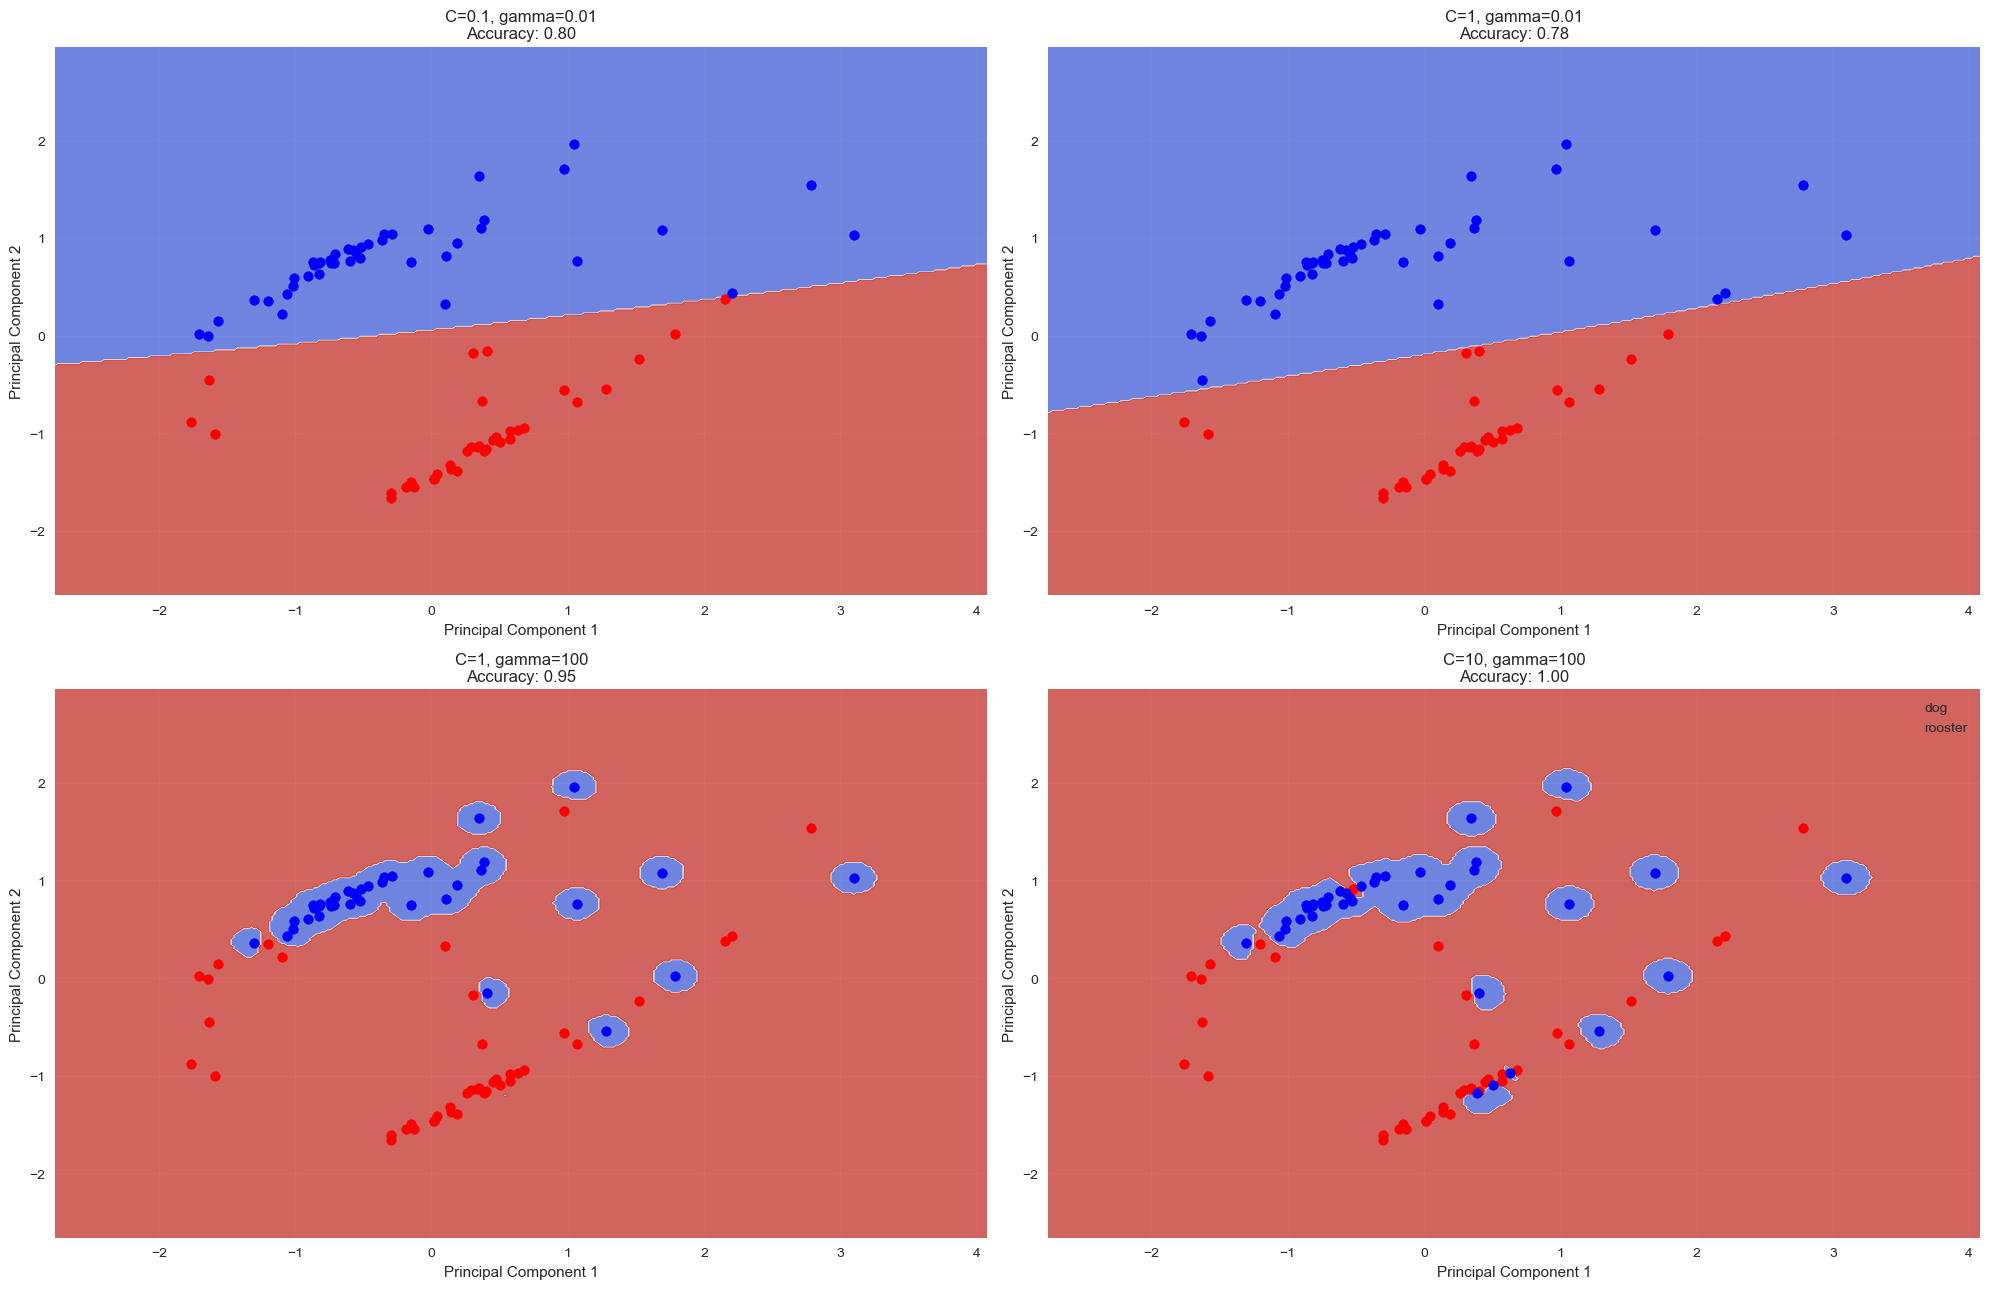

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Parameters 
C_values = [0.1, 1, 1, 10]
gamma_values = [0.01, 0.01, 100, 100]

# Figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 13))
axes = axes.ravel()  

# Grid for contour plot
h = 0.02
x_min, x_max = Y[:,0].min() -1 , Y[:,0].max() +1
y_min, y_max = Y[:,1].min() -1 , Y[:,1].max() +1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min, y_max,h))

# Loop over the parameters
for i in range(4):
    C = C_values[i]
    gamma = gamma_values[i]

    model = SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(Y, labels_gt)
    labels = model.predict(Y)
    acc = accuracy_score(labels_gt, labels)

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax = axes[i]
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(Y[labels==1,0], Y[labels==1,1], c='r')
    ax.scatter(Y[labels==0,0], Y[labels==0,1], c='b')
    ax.set_title(f'C={C}, gamma={gamma}\nAccuracy: {acc:.2f}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

plt.tight_layout()
plt.legend(['dog', 'rooster'], loc='upper right')
plt.show()


### Comment on SVM with RBF Kernel - Effect of C and Gamma

- **`C` (Regularization parameter)**: Controls the trade-off between achieving a low training error and a low testing error (i.e., generalization).  
  - **Small `C`** → More regularization → Simpler decision boundary (higher bias, lower variance).  
  - **Large `C`** → Less regularization → Complex boundary that fits the training data closely (lower bias, higher variance).

- **`gamma` (Kernel coefficient)**: Determines the influence range of a single training example.  
  - **Small `gamma`** → Large influence area → Smoother, more generalized boundary.  
  - **Large `gamma`** → Small influence area → Very flexible boundary that may overfit.

---

### Subplot Analysis

The subplot grid shows how varying the parameters `C` and `gamma` in an RBF kernel affects classification performance:

- **Top-left (C=0.1, gamma=0.01)**  
  Underfitting: The decision boundary is nearly linear and doesn't capture the data distribution well. Accuracy: **0.80**

- **Top-right (C=1, gamma=0.01)**  
  Still underfitting, though slightly better. The boundary is a bit more flexible. Accuracy: **0.78**

- **Bottom-left (C=1, gamma=100)**  
  High flexibility due to large gamma. The model captures the structure better but shows signs of **overfitting**. Accuracy: **0.95**

- **Bottom-right (C=10, gamma=100)**  
  Clear **overfitting**: the boundary wraps tightly around training points, leading to perfect accuracy **(1.00)** on the training set but likely poor generalization on unseen data.




# Exercise 11. Support Vector Machine
Cluster the PCA projected data into **2** groups using k-Means (see sklearn.cluster.KMeans).

In [125]:
### START CODING ###
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak*")

input = Y

# Initialize and fit the model
model = KMeans(n_clusters=2, n_init='auto')
model.fit(input)

# Get the predicted cluster labels
labels = model.labels_

acc = sklearn.metrics.accuracy_score(labels_gt, labels)
# Account for possible inversion
if 1-acc > acc:
  acc = 1-acc
  labels = 1 - labels

print(f'Accuracy: {acc}')

Accuracy: 0.75


Represent the scatterplots of the original data and the two resultant clusters. Plot the final k-Means centroids as well.

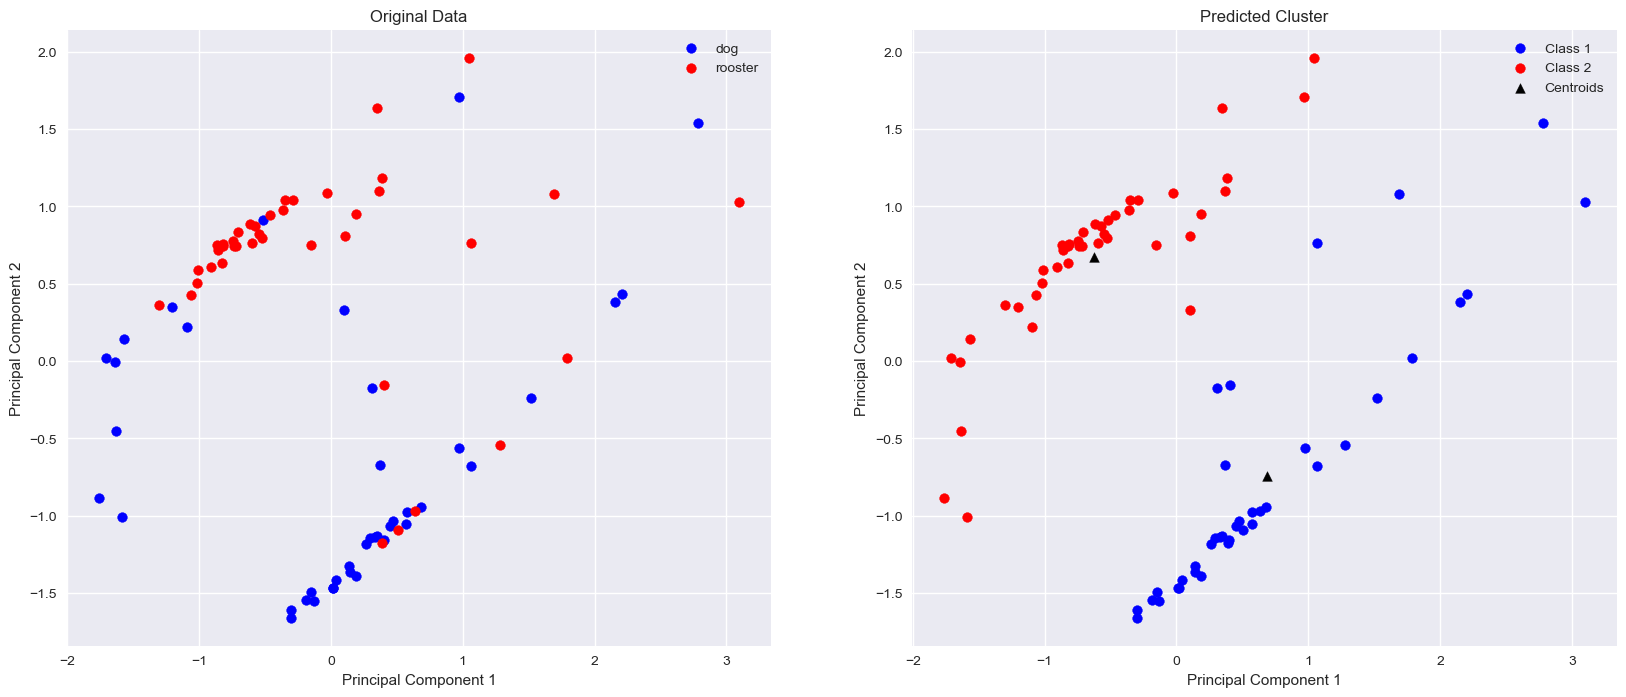

In [126]:
plt.figure(figsize=(20,8))

#Ground Truth Data
plt.subplot(1,2,1)
plt.scatter(input[labels_gt==1,0], input[labels_gt==1,1], c='b')
plt.scatter(input[labels_gt==0,0], input[labels_gt==0,1], c='r')
plt.title('Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(('dog', 'rooster'))

#Classification Result
plt.subplot(1,2,2)
plt.scatter(input[labels==1,0], input[labels==1,1], c='b')
plt.scatter(input[labels==0,0], input[labels==0,1], c='r')
plt.title('Predicted Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(model.cluster_centers_[:,0] ,model.cluster_centers_[:,1], color='black', marker='^')
plt.legend(('Class 1', 'Class 2', 'Centroids'));

### K-Means Clustering Result

The left plot shows the **ground truth labels** (dog vs rooster), while the right plot displays the **K-Means clustering result** after PCA dimensionality reduction, including the final centroids (black triangles).

- The clustering does **partially match** the true labels, with some visible misclassifications between the two classes.
- The **accuracy of around 75%** indicates that K-Means was able to detect a general separation, but not perfectly. This is expected, since **K-Means is unsupervised** and has no knowledge of the true class labels.
- The **centroids** are well positioned in dense areas, showing the algorithm has captured the core distribution of the data.

K-Means provides a reasonable separation, but with limited precision compared to supervised approaches like SVM.



# Exercise 12. k-NN
Fit a k-NN classifier (sklearn.neighbors.KNeighborsClassifier) to the same data and experiment with different k parameters. Discuss the results.

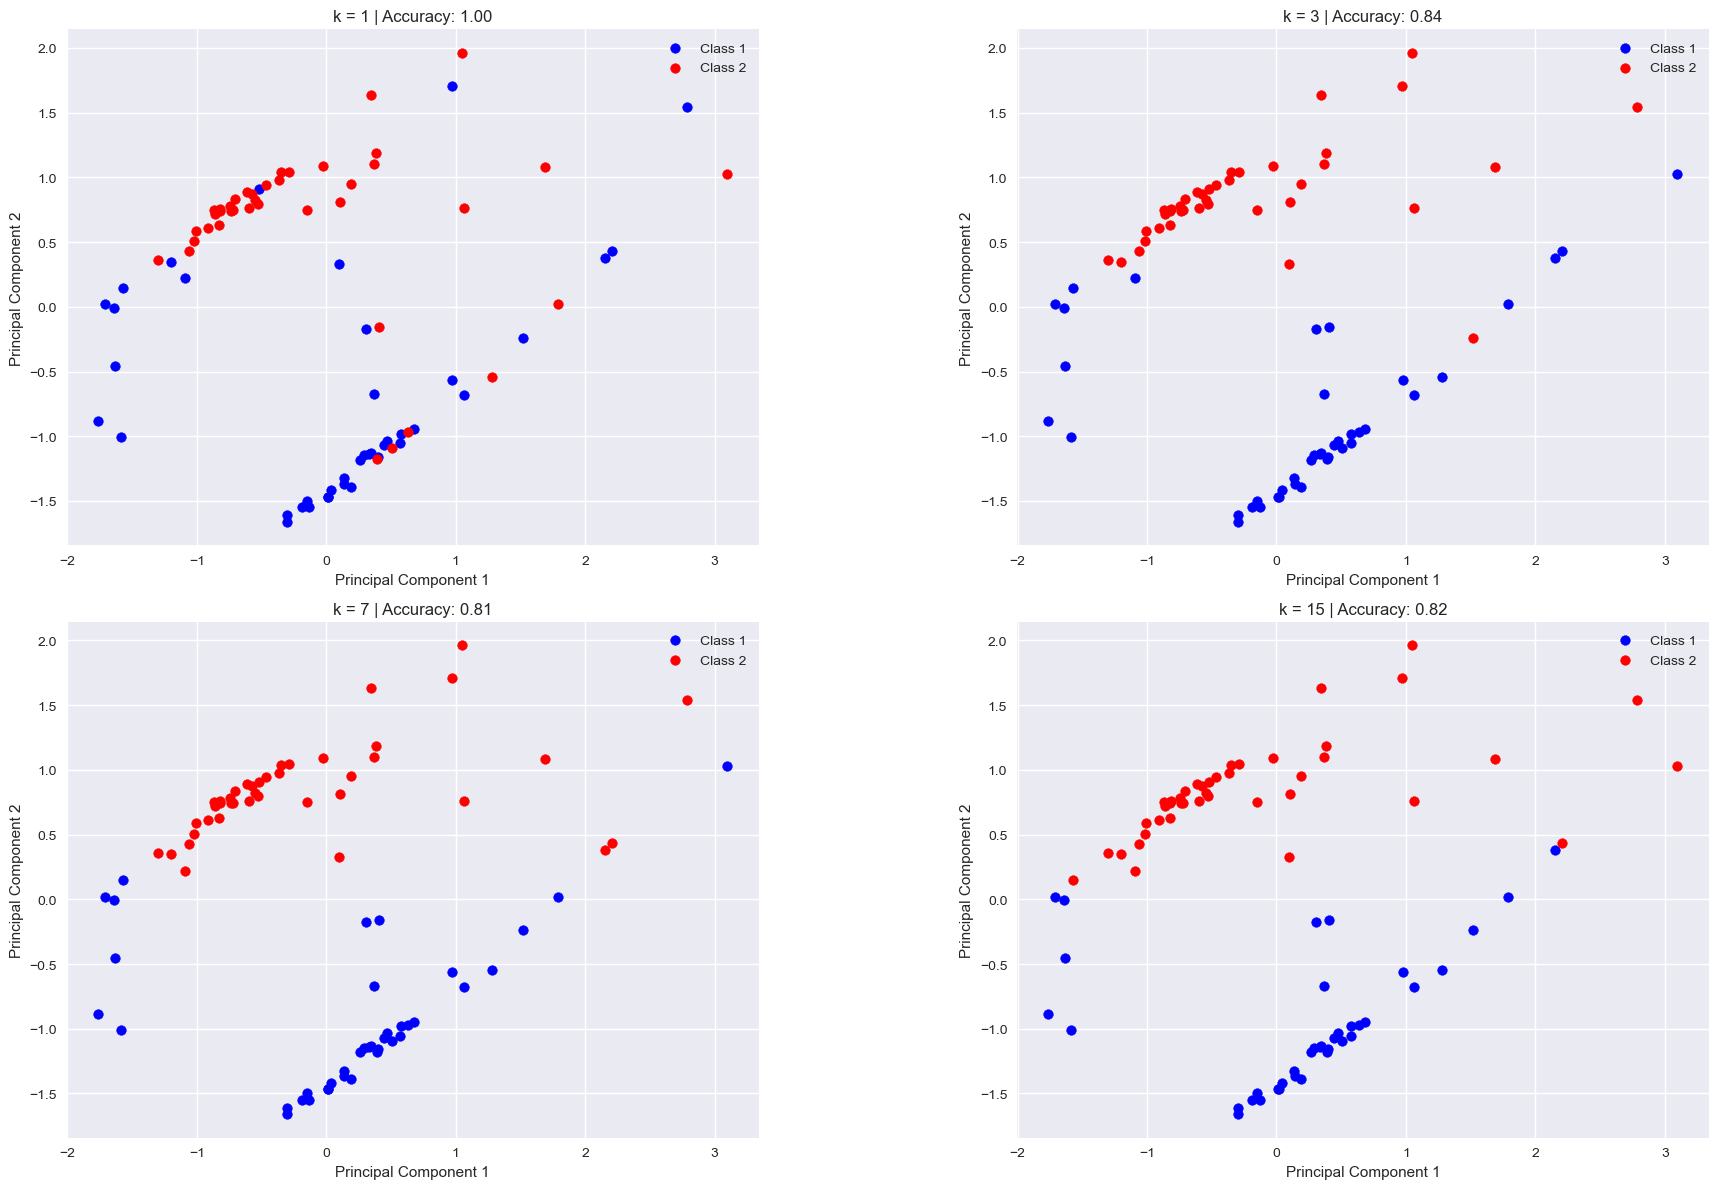

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = [1, 3, 7, 15]  # valori di k da confrontare
plt.figure(figsize=(20, 12))

for i, k_param in enumerate(k_values):
    # Modello k-NN
    model = KNeighborsClassifier(n_neighbors=k_param)
    model.fit(X, labels_gt)
    labels = model.predict(X)

    # Calcolo accuracy
    acc = accuracy_score(labels_gt, labels)

    # Plot
    ax = plt.subplot(2, 2, i+1)
    plt.scatter(X[labels==1, 0], X[labels==1, 1], c='b')
    plt.scatter(X[labels==0, 0], X[labels==0, 1], c='r')
    plt.title(f'k = {k_param} | Accuracy: {acc:.2f}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(['Class 1', 'Class 2'])
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


### k-NN Classification Results

The *k* parameter in the **k-Nearest Neighbors (k-NN)** algorithm defines how many neighbors are considered when assigning a class to a new data point. The model assigns the label by majority voting among the *k* closest training examples. This makes *k* a crucial parameter: 

- **Small k values** (e.g., k=1) tend to fit the training data perfectly but can lead to **overfitting**, making the model too sensitive to noise.
- **Larger k values** (e.g., k=15) smooth out the decision boundary, leading to **underfitting**, as the model becomes too general and may ignore local patterns.

#### Observations from the plots:
- **k = 1** yields a perfect accuracy of **1.00**, but this is likely overfitting as it memorizes training data.
- As **k increases** (3, 7, 15), the **accuracy slightly decreases** (down to ~0.82), indicating more general decision boundaries.
- The **decision boundaries become smoother** and more stable with higher *k*, but at the cost of potentially ignoring finer structure in the data.

In conclusion, choosing the right *k* is a **bias-variance tradeoff**: low *k* → low bias, high variance; high *k* → high bias, low variance. A good value is often found via cross-validation.
